In [69]:
from __future__ import unicode_literals, print_function, division
import numpy as np
import torch
from torch import nn

In [70]:
class DataReader:
  def __init__(self):
    self.data = "Acknowledgement"
    chars = list(set(self.data))
    chars.append(" ")
    self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
    self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
    self.seq_length = len(self.data)
    self.vocab_size = len(chars)

  def get_inputs_targets(self, data):
   inputs_str = data
   target_str = data[1:]    
   target_str = target_str + " "
   inputs = [self.char_to_ix[ch] for ch in inputs_str] 
   targets = [self.char_to_ix[ch] for ch in target_str]
   return inputs, targets

datareader = DataReader()
input_seq, target_seq = datareader.get_inputs_targets(datareader.data)


In [71]:
dict_size = len(datareader.char_to_ix)
seq_len = datareader.seq_length
batch_size = 1

features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
for i in range(batch_size):
    for u in range(seq_len):
        features[i, u, input_seq[u]] = 1

input_seq = torch.from_numpy(features)
target_seq = torch.Tensor(target_seq)

In [72]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        if hidden is None:
          hidden = self.init_hidden(batch_size)
        else: 
          hidden = hidden
        out, hidden = self.rnn(x, hidden)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [73]:
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=5, n_layers=1)

n_epochs = 10000
lr = 0.09

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [74]:
losses = []
iterations = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() 
    output, hidden = model(input_seq, None)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward()
    optimizer.step() 
    
    if epoch%250 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
        losses.append(loss.item())
        iterations.append(epoch)



Epoch: 250/10000............. Loss: 1.0653
Epoch: 500/10000............. Loss: 0.4929
Epoch: 750/10000............. Loss: 0.2790
Epoch: 1000/10000............. Loss: 0.1582
Epoch: 1250/10000............. Loss: 0.1056
Epoch: 1500/10000............. Loss: 0.0787
Epoch: 1750/10000............. Loss: 0.0627
Epoch: 2000/10000............. Loss: 0.0520
Epoch: 2250/10000............. Loss: 0.0444
Epoch: 2500/10000............. Loss: 0.0387
Epoch: 2750/10000............. Loss: 0.0343
Epoch: 3000/10000............. Loss: 0.0307
Epoch: 3250/10000............. Loss: 0.0279
Epoch: 3500/10000............. Loss: 0.0255
Epoch: 3750/10000............. Loss: 0.0235
Epoch: 4000/10000............. Loss: 0.0218
Epoch: 4250/10000............. Loss: 0.0203
Epoch: 4500/10000............. Loss: 0.0190
Epoch: 4750/10000............. Loss: 0.0179
Epoch: 5000/10000............. Loss: 0.0168
Epoch: 5250/10000............. Loss: 0.0159
Epoch: 5500/10000............. Loss: 0.0151
Epoch: 5750/10000............. Loss

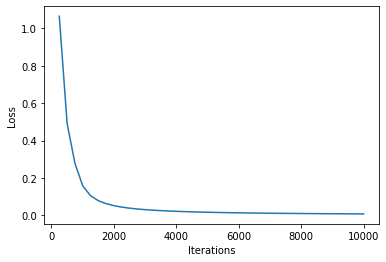

In [75]:
import matplotlib.pyplot as plt
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(iterations, losses)

In [76]:
def predict(character, predict_len):
        data = datareader.data
        hidden = None
        header = ""
        for i in range(len(data)):
            if data[i] != character[0]:
                header += data[i]
            else:
                break 

        if header != "":
            header = np.array([datareader.char_to_ix[c] for c in header])
            features = np.zeros((batch_size, len(header), dict_size), dtype=np.float32)
            for i in range(batch_size):
                for u in range(len(header)):
                    features[i, u, header[u]] = 1    
            data = torch.from_numpy(features)
            op1, hidden = model.forward(data, None)

        for i in range(predict_len):
            char = np.array([datareader.char_to_ix[c] for c in character])
            features = np.zeros((batch_size, len(character), dict_size), dtype=np.float32)
            for i in range(batch_size):
                for u in range(len(char)):
                    features[i, u, char[u]] = 1    
            char = torch.from_numpy(features)
            output, hid = model.forward(char, hidden)
            prob = nn.functional.softmax(output[-1], dim=0).data
            ind = torch.max(prob, dim=0)[1].item()
            character += datareader.ix_to_char[ind]
        return character

In [77]:
predict('A', datareader.seq_length)

'Acknowledgement '

In [78]:
predict('e', 8)

'edgement '